In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/Homeworks/HW7

/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Homeworks/HW7


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


# Download MNIST data

In [12]:
# Set seed for repeatability
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

# Define the validation ratio to be used
valid_ratio = 0.3

# Transform data to improve generalizability
transform = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Load in the datasets
train_valid_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Number of images to use for training
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
# Number of images to use for validation
nb_valid =  int(valid_ratio * len(train_valid_dataset))
# Randomly split into training and validation data
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

# Put into dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=500, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)

In [13]:
batch = next(iter(trainloader))
batch[0].shape

torch.Size([500, 1, 28, 28])

# <font color=red>TO-DO #1. </font> Variational Auto-encoder

<font color=red>Complete the code below to create a variational auto-encoder. </font> The variational auto-encoder should have the following modules

1. An encoder nn.Sequential, consisting of
>* Linear layer that takes in image size and outputs h_dim channels, followed by a LeakyReLU(0.2),
>* Linear layer that takes in h_dim channels and outputs h_dim channels, followed by a LeakyReLU(0.2),
>* Linear layer that takes in h_dim channels and outputs z_dim*2 channels




2. An decoder implemented using nn.Sequential, consisting of
>* Linear layer that takes in z_dim channels and outputs h_dim channels, followed by LeakyReLU(0.2)
>* Linear layer that takes in h_dim channels and outputs h_dim channels, followed by LeakyReLU(0.2)
>* Linear layer that takes in h_dim channels and outputs image size channels, followed by Sigmoid activation

3. An resampling layer, with inputs logvar and mu

  Here logvar_i $= \log (\sigma_i^2) $, where $\sigma_i$ is the standard deviation along the $i^{\rm th}$ direction. The z vector is obtained as

  $$z_i = \mu_i + \sigma_i ~ n_i,$$

where $n_i$ is zero mean Gaussian noise with unit variance. When there are z_dim=2, $\boldsymbol \mu = (\mu_1,\mu_2)$

4. A forward method, which calls
>* Encoder
>* Resampling layer, which uses the mean and logvar parameters
>* Decoder

and returns the images, mu, and logvar parameters


In [29]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )

    def resample(self, mu, logvar):
        # YOUR CODE HERE
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1) #split the output of the encoder into mu and logvar
        z = self.resample(mu, logvar)
        return self.decoder(z), mu, logvar

 # <font color=red>TO-DO #2. </font>  Define the loss function

<font color=red> Complete the code below to define the auto-encoder loss function, consisting of binary cross-entropy loss and KL divergence loss. </font>

$L(\theta,\phi) = \sum_{x_i \sim p(x)}\left(\underbrace{\mathbb E_{\mathbf h \sim q_{\phi}(h|\mathbf x_i)} BCE\left(g_{\theta}({\mathbf h}),\mathbf x_i\right)}_{\mbox{data term}}-  \underbrace{\frac{1}{2}\left[\sum_{i=1}^d(1+\log\sigma_i^2 - \sigma_i^2- \mu_i^2)\right]}_{\mbox{deviation from prior; zero mean unit Gaussian}}\right) $

Here, BCE denotes the binary cross entropy loss between the output of the decoder $g_{\theta}(\mathbf h)$ and the true output $\mathbf x_i$
Note that the auto-encoder is outputing ${\rm logvar}=\log \sigma^2$, and hence $\sigma^2 = \exp(\rm logvar)$. Please use <font color=red>F.binary_cross_entropy</font> loss to implement BCE. Note that the auto-encoder is outputing ${\rm logvar}=\log \sigma^2$, and hence $\sigma^2 = \exp(\rm logvar)$

In [35]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum') # data term
    KLD = -0.5 * torch.sum(1 + logvar - torch.square(mu) - logvar.exp()) # regularization term
    return BCE + KLD


In [36]:

def flatten(x):
    return to_var(x.view(x.size(0), -1))

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

 # <font color=red>TO-DO #3. </font>  VAE optimization

In [37]:
# data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
#next(iter(data_loader))
data_loader = trainloader

In [38]:
# data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

vae = VAE()
if torch.cuda.is_available():
    vae.cuda()

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 40
for epoch in range(epochs):
  for idx, (images, _) in enumerate(data_loader):
   # YOUR CODE HERE
   images = flatten(images)
   images = images.cuda()
   optimizer.zero_grad()
   recon_images, mu, logvar = vae(images)
   loss = loss_fn(recon_images, images, mu, logvar) / images.size(0)
   loss.backward()
   optimizer.step()

  print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/images.shape[0]))



Epoch[1/40] Loss: 0.972
Epoch[2/40] Loss: 0.946
Epoch[3/40] Loss: 0.932
Epoch[4/40] Loss: 0.932
Epoch[5/40] Loss: 0.921
Epoch[6/40] Loss: 0.924
Epoch[7/40] Loss: 0.914
Epoch[8/40] Loss: 0.911
Epoch[9/40] Loss: 0.920
Epoch[10/40] Loss: 0.902
Epoch[11/40] Loss: 0.915
Epoch[12/40] Loss: 0.910
Epoch[13/40] Loss: 0.905
Epoch[14/40] Loss: 0.921
Epoch[15/40] Loss: 0.914
Epoch[16/40] Loss: 0.910
Epoch[17/40] Loss: 0.911
Epoch[18/40] Loss: 0.912
Epoch[19/40] Loss: 0.902
Epoch[20/40] Loss: 0.910
Epoch[21/40] Loss: 0.908
Epoch[22/40] Loss: 0.909
Epoch[23/40] Loss: 0.900
Epoch[24/40] Loss: 0.890
Epoch[25/40] Loss: 0.904
Epoch[26/40] Loss: 0.900
Epoch[27/40] Loss: 0.901
Epoch[28/40] Loss: 0.892
Epoch[29/40] Loss: 0.895
Epoch[30/40] Loss: 0.899
Epoch[31/40] Loss: 0.903
Epoch[32/40] Loss: 0.897
Epoch[33/40] Loss: 0.899
Epoch[34/40] Loss: 0.890
Epoch[35/40] Loss: 0.898
Epoch[36/40] Loss: 0.899
Epoch[37/40] Loss: 0.890
Epoch[38/40] Loss: 0.900
Epoch[39/40] Loss: 0.893
Epoch[40/40] Loss: 0.901


# Visualize the embedding

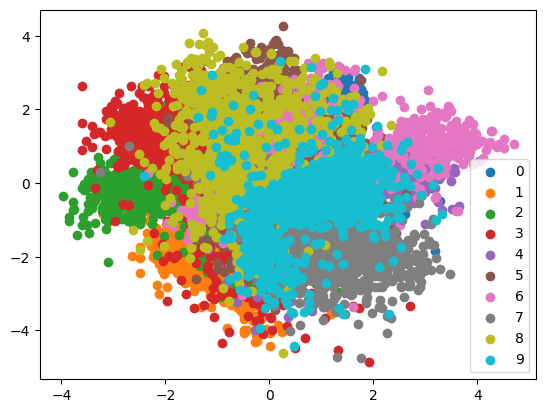

In [41]:
display_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25000, shuffle=True)

images, labels = next(iter(display_loader))
images = flatten(images)
recon_images, mu, logvar = vae(images)
mu = mu.detach().cpu()

plt.figure()
legtext = []

for i in range(10):
  idx = (labels ==i)
  plt.scatter(mu[idx,0],mu[idx,1])
  legtext = np.hstack((legtext,str(i)))
  plt.legend(legtext)

<Figure size 1800x1800 with 0 Axes>

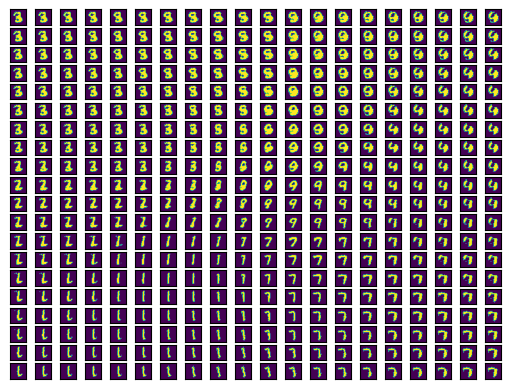

In [42]:

mtx_size = 20
[x,y] = np.meshgrid(np.linspace(-4,4,mtx_size),np.linspace(4,-4,mtx_size))
embedding = np.stack((x.ravel(),y.ravel()))
embedding = torch.tensor(embedding).T.cuda()
embedding = embedding.type(torch.cuda.FloatTensor)
recons = vae.decoder(embedding)
recons = recons.detach().cpu().numpy()

recons.shape
plt.figure(figsize=(18, 18))
fig,ax = plt.subplots(mtx_size,mtx_size)

i = 0
for x in range(mtx_size):
  for y in range(mtx_size):
    i = x*mtx_size + y
    ax[x][y].imshow(np.reshape(recons[i,],(28,28)))
    ax[x][y].get_xaxis().set_visible(False)
    ax[x][y].get_yaxis().set_visible(False)